# Extract mix features from the packets
## import libs

In [218]:
import os
import pyshark
import numpy as np
import matplotlib.pyplot as plt
import pywt
import nest_asyncio
nest_asyncio.apply()
import pyshark
import numpy as np
from scipy.interpolate import interp1d
import pyshark
import numpy as np
from scipy.interpolate import interp1d

In [219]:
def read_capture(cap):


    timestamps = []
    atkflags = []

    # read pcap file to packets
    for packet in cap:
        if 'IP' in packet:  # 只处理包含IP层的包
            timestamps.append(float(packet.sniff_timestamp))
            if 'UDP' in packet:  # 只处理包含UDP层的包
                if hasattr(packet['UDP'], 'payload'):  # 确保存在UDP数据负载
                    udp_payload = packet['UDP'].payload
                    sliced_data = udp_payload[129:131] # atk flag
                    atkflags.append(int(sliced_data, 16))
                    # print("sliced data: ", sliced_data)
                    if sliced_data != '00' and int(sliced_data, 16) > 10:
                        print("related data: ", udp_payload[120:140])
                        # print pack no
                        print("packet no: ", packet.number)
                else:
                    atkflags.append(int('00', 16))
            else:
                atkflags.append(int('00', 16))
    cap.close()

    # 转换为流量时间序列
    timestamps = np.array(timestamps)
    relative_time = timestamps - timestamps[0]  # 转换为相对时间

    atkflags = np.array(atkflags)

    print(atkflags.shape)
    print(relative_time.shape)

    return relative_time, atkflags 
def extract_traffic_features(cap, time_window=0.01):
    
    timestamps = []
    atkflags = []
    
    for packet in cap:
        if 'IP' in packet:  # 只处理包含IP层的包
            timestamps.append(float(packet.sniff_timestamp))
            if 'UDP' in packet:  # 只处理包含UDP层的包
                if hasattr(packet['UDP'], 'payload'):  # 确保存在UDP数据负载
                    udp_payload = packet['UDP'].payload
                    sliced_data = udp_payload[129:131] # atk flag
                    atkflags.append(int(sliced_data, 16))
                    # print("sliced data: ", sliced_data)
                    if sliced_data != '00' and int(sliced_data, 16) > 10:
                        print("related data: ", udp_payload[120:140])
                        # print pack no
                        print("packet no: ", packet.number)
                else:
                    atkflags.append(int('00', 16))
            else:
                atkflags.append(int('00', 16))
    cap.close()
    print("attack flags detected in the pcap file:")
    print(atkflags)


    
    # 转换为流量时间序列
    timestamps = np.array(timestamps)
    relative_time = timestamps - timestamps[0]  # 转换为相对时间
    
    # 计算每个time_window内的包的数量
    num_buckets = int(np.ceil(relative_time[-1] / time_window))  # 计算时间片的数量
    
    # 初始化一个列表用于存储每个时间片内的包数量
    packet_counts = np.zeros(num_buckets, dtype=int)
    
    # 遍历每个包，统计它属于哪个时间片
    for t in relative_time:
        bucket_index = int(t // time_window)  # 计算该包属于哪个时间片
        packet_counts[bucket_index] += 1
    
    # 计算采样率 (每秒钟包的数量)
    total_time_seconds = relative_time[-1]  # 计算总的相对时间
    total_packets = len(relative_time)  # 总的包数量
    sample_rate = total_packets / total_time_seconds  # 采样率: 每秒钟的包数量


    # Macro attack flag
    # if exist not zero attack flag, these packets contain attack
    macro_atkflag = 0
    for i in range(len(atkflags)):
        if atkflags[i] != 0:
            macro_atkflag = atkflags[i]
            break
    
    return relative_time, packet_counts, sample_rate, atkflags, macro_atkflag


# Step 2: 计算连续小波变换 (CWT)
def perform_cwt(time_series, sampling_rate, freq_min, freq_max, wavelet='cmor', scale_num = 200):
    """
    计算连续小波变换 (CWT)，限制频率范围为 [freq_min, freq_max]。

    :param time_series: 输入时间序列
    :param sampling_rate: 时间序列的采样率 (Hz)
    :param freq_min: 分析的最小频率 (Hz)
    :param freq_max: 分析的最大频率 (Hz)
    :param wavelet: 小波基，默认为 'cmor'
    :return: 小波变换系数 (coeffs) 和频率 (freqs)
    """
    sampling_period = 1 / sampling_rate  # 采样周期 (秒)
    
    # 根据频率范围计算尺度范围
    center_frequency = pywt.scale2frequency(wavelet, 1)  # 小波基的中心频率
    scale_min = center_frequency / (freq_max * sampling_period)  # 最小尺度
    scale_max = center_frequency / (freq_min * sampling_period)  # 最大尺度
    
    # 定义尺度范围
    scales = np.linspace(scale_min, scale_max, scale_num)  # 生成 200 个等间隔的尺度
    
    # 计算 CWT
    coeffs, freqs = pywt.cwt(time_series, scales, wavelet, sampling_period=sampling_period)
    return coeffs, freqs


# Step 3: 绘制和保存小波变换图像
def plot_and_save_cwt(coeffs, freqs, timestamps, output_file, title="CWT of Traffic Features"):
    plt.figure(figsize=(3, ))
    plt.imshow(
        np.abs(coeffs), extent=[timestamps[0], timestamps[-1], freqs[-1], freqs[0]],
        cmap='jet', aspect='auto'
    )
    plt.colorbar(label='Magnitude')
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    if output_file is not None:
        plt.savefig(output_file)
    plt.show()


def plot_resized_data(time, packet_counts, target_size=None, atk_flags = None, macro_atkflag = None):
    """
    将 packet_counts 数组根据 time 数组调整为统一大小并绘制图像。

    参数:
    - time: 时间数组（一维数组）。
    - packet_counts: 包计数数组（一维数组）。
    - target_size: 目标数组大小，默认与 time 数组大小一致。如果给定，则强制调整为此大小。

    返回:
    - resized_packet_counts: 调整大小后的 packet_counts 数组。
    """
    # 如果没有提供目标大小，则使用 time 数组的大小
    if target_size is None:
        target_size = len(time)
    
    # 使用线性插值调整 packet_counts 的大小
    interpolator = interp1d(np.linspace(0, 1, len(packet_counts)), packet_counts, kind='linear')
    resized_packet_counts = interpolator(np.linspace(0, 1, target_size))

    # 如果提供了攻击标志，则绘制攻击标志
    if atk_flags is not None:
        # 绘制攻击标志
        plt.figure(figsize=(2.5, 1.5))
        plt.plot(time, resized_packet_counts, label='Packet Counts', zorder = 1)
        plt.plot(time, atk_flags, c='red', label='Attack Flags', zorder = 2)
        plt.xlabel('Time')
        plt.ylabel('Packet Counts')
        plt.title('Time vs Packet Counts')
        plt.legend()
        plt.grid(True)
        plt.show()
        return resized_packet_counts
    # name title with macro attack flag
    title = 'Time vs Packet Counts'
    if macro_atkflag is not None:
        if macro_atkflag != 0:
            title = 'Time vs Packet Counts (Macro Attack Flag: {})'.format(macro_atkflag)

    # 绘制图像
    plt.figure(figsize=(2.5, 1.5))
    plt.plot(time, resized_packet_counts, label='Packet Counts')
    plt.xlabel('Time')
    plt.ylabel('Packet Counts')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

    return resized_packet_counts

def read_capture(pcap_file):
    pcap_file = '60smix2.pcapng'
    cap = pyshark.FileCapture(pcap_file)

    timestamps = []
    atkflags = []

    # read pcap file to packets
    for packet in cap:
        if 'IP' in packet:  # 只处理包含IP层的包
            timestamps.append(float(packet.sniff_timestamp))
            if 'UDP' in packet:  # 只处理包含UDP层的包
                if hasattr(packet['UDP'], 'payload'):  # 确保存在UDP数据负载
                    udp_payload = packet['UDP'].payload
                    sliced_data = udp_payload[129:131] # atk flag
                    atkflags.append(int(sliced_data, 16))
                    # print("sliced data: ", sliced_data)
                    if sliced_data != '00' and int(sliced_data, 16) > 10:
                        print("related data: ", udp_payload[120:140])
                        # print pack no
                        print("packet no: ", packet.number)
                else:
                    atkflags.append(int('00', 16))
            else:
                atkflags.append(int('00', 16))
    cap.close()

    # 转换为流量时间序列
    timestamps = np.array(timestamps)
    relative_time = timestamps - timestamps[0]  # 转换为相对时间

    atkflags = np.array(atkflags)

    print(atkflags.shape)
    print(relative_time.shape)

    return relative_time, atkflags 
def calculate_packet_count(relative_time ,time_window = 0.01):
    num_buckets = int(np.ceil(relative_time[-1] / time_window))  # 计算时间片的数量
    # 初始化一个列表用于存储每个时间片内的包数量
    packet_counts = np.zeros(num_buckets, dtype=int)

    # 遍历每个包，统计它属于哪个时间片
    for t in relative_time:
        bucket_index = int(t // time_window)  # 计算该包属于哪个时间片
        packet_counts[bucket_index] += 1

    # 计算采样率 (每秒钟包的数量)
    total_time_seconds = relative_time[-1]  # 计算总的相对时间
    total_packets = len(relative_time)  # 总的包数量
    sample_rate = total_packets / total_time_seconds  # 采样率: 每秒钟的包数量

    return packet_counts, sample_rate
def cut_data_by_time(relative_time, atkflags, start_time, end_time):
    # find the index of start time and end time
    start_index = np.where(relative_time >= start_time)[0][0]
    end_index = np.where(relative_time >= end_time)[0][0]

    # cut the data
    relative_time = relative_time[start_index:end_index]
    atkflags = atkflags[start_index:end_index]

    # normalize the time
    relative_time = relative_time - relative_time[0]

    return relative_time, atkflags

def export_dwt_image(relative_time1, atkflags1, coeffs, freqs, output_path):
    
    macro_atkflag = 0
    # for i in range(len(atkflags1)):
    #     if atkflags1[i] != 0:
    #         macro_atkflag = atkflags1[i]
    #         break

    # find how many flags 0,1,2,3
    # use the most frequent flag as macro attack flag
    flag0_cnt = 0
    flag1_cnt = 0
    flag2_cnt = 0
    flag3_cnt = 0
    # print the type and value of atkflags1
    print("type of atkflags1: ", type(atkflags1))
    print("value of atkflags1: ", atkflags1)

    for i in range(len(atkflags1)):
        if atkflags1[i] == 0:
            flag0_cnt += 1
        elif atkflags1[i] == 1:
            flag1_cnt += 1
        elif atkflags1[i] == 2:
            flag2_cnt += 1
        elif atkflags1[i] == 3:
            flag3_cnt += 1
    
    # find the max in flag cnts, if flag0_cnt is the max, then macro attack flag is 0
    # if flag1_cnt is the max, then macro attack flag is 1
    # if flag2_cnt is the max, then macro attack flag is 2
    # if flag3_cnt is the max, then macro attack flag is 3
    # max_cnt = max(flag0_cnt, flag1_cnt, flag2_cnt, flag3_cnt)
    # if max_cnt == flag0_cnt:
    #     macro_atkflag = 0
    # elif max_cnt == flag1_cnt:
    #     macro_atkflag = 1
    # elif max_cnt == flag2_cnt:
    #     macro_atkflag = 2
    # elif max_cnt == flag3_cnt:
    #     macro_atkflag = 3
    
    # if any flag count is not zero, and count number is larger than 10, then this is the macro attack flag
    if flag1_cnt > 10:
        macro_atkflag = 1
    elif flag2_cnt > 100:
        macro_atkflag = 2
    elif flag3_cnt > 10:
        macro_atkflag = 3
    else:
        macro_atkflag = 0

    print(flag0_cnt, flag1_cnt, flag2_cnt, flag3_cnt)

    print("macro attack flag: ", macro_atkflag)
    print(np.shape(coeffs))
    print(np.shape(freqs))

    plt.figure(figsize=(10, 6))
    plt.imshow(np.abs(coeffs), aspect='auto', extent=[relative_time1[0], relative_time1[-1], freqs[-1], freqs[0]], cmap='jet')


    plt.title("")  
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks([])
    plt.yticks([])

    output_file = output_path+ '_' + str(macro_atkflag) + '.png'

    plt.savefig(output_file, dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)
    plt.close()



## read files from the capture
### overview of the data

In [220]:
# macro define of the paras

pcap_file = "60smix3.pcapng"
output_file = 'cwt_traffic_features_0_200hz.png'

attack flags detected in the pcap file:
[0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

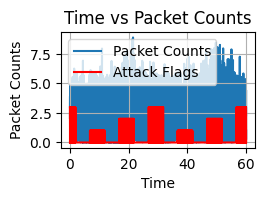

array([3.        , 3.        , 3.        , ..., 0.23733346, 0.61866673,
       1.        ])

In [221]:
# 提取流量特征
cap = pyshark.FileCapture(pcap_file)
time, packet_counts, sample_rate , atk_flags, macro_atkflag = extract_traffic_features(cap, time_window=0.0038)
plot_resized_data(time, packet_counts, None, atk_flags, macro_atkflag)


In [222]:
pcap_file = '60smix3.pcapng'
cap = pyshark.FileCapture(pcap_file)
relative_time, atkflags = read_capture(cap)


sample_number = 1600

time_interval = (58 - 1) / sample_number

# clear the files in cwt_images folder
os.system("rm -rf cwt_images/*")

for i in range(0, sample_number):
    start_time = 1 + i * time_interval
    end_time = start_time + 2
    
    relative_time1, atkflags1 = cut_data_by_time(relative_time, atkflags, start_time, end_time)
    packet_counts, sample_rate = calculate_packet_count(relative_time1 ,time_window = 0.00038)
    # plot_resized_data(relative_time1, packet_counts, target_size=None, atk_flags = atkflags1, macro_atkflag = None)
    coeffs, freqs = perform_cwt(packet_counts, sample_rate, freq_min=0.1, freq_max=100, wavelet='morl', scale_num = 20)
    output_path = 'cwt_images/' + str(i)
    export_dwt_image(relative_time1, atkflags1, coeffs, freqs, output_path)
    # plot_and_save_cwt(coeffs, freqs, relative_time1, None, title="CWT of Traffic Features (0-100Hz)")

(39916,)
(39916,)
type of atkflags1:  <class 'numpy.ndarray'>
value of atkflags1:  [0 0 0 ... 0 0 0]
1270 0 0 0
macro attack flag:  0
(20, 5263)
(20,)
type of atkflags1:  <class 'numpy.ndarray'>
value of atkflags1:  [0 0 0 ... 0 0 0]
1272 0 0 0
macro attack flag:  0
(20, 5254)
(20,)
type of atkflags1:  <class 'numpy.ndarray'>
value of atkflags1:  [0 0 0 ... 0 0 0]
1271 0 0 0
macro attack flag:  0
(20, 5249)
(20,)
type of atkflags1:  <class 'numpy.ndarray'>
value of atkflags1:  [0 0 0 ... 0 0 0]
1274 0 0 0
macro attack flag:  0
(20, 5260)
(20,)
type of atkflags1:  <class 'numpy.ndarray'>
value of atkflags1:  [0 0 0 ... 0 0 0]
1274 0 0 0
macro attack flag:  0
(20, 5257)
(20,)
type of atkflags1:  <class 'numpy.ndarray'>
value of atkflags1:  [0 0 0 ... 0 0 0]
1272 0 0 0
macro attack flag:  0
(20, 5258)
(20,)
type of atkflags1:  <class 'numpy.ndarray'>
value of atkflags1:  [0 0 0 ... 0 0 0]
1272 0 0 0
macro attack flag:  0
(20, 5258)
(20,)
type of atkflags1:  <class 'numpy.ndarray'>
value o

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
def test (off, mtime_window, msample_number):
    time_points = [2, 6, 18, 28]
    for i in range(1, 5):
        start_time = time_points[i-1] +off
        end_time = start_time + 2
        relative_time1, atkflags1 = cut_data_by_time(relative_time, atkflags, start_time, end_time)
        # print(relative_time1.shape)
        # print(atkflags1.shape)


        packet_counts, sample_rate = calculate_packet_count(relative_time1 ,mtime_window)
        #plot_resized_data(relative_time1, packet_counts, target_size=None, atk_flags = atkflags1, macro_atkflag = None)
        coeffs, freqs = perform_cwt(packet_counts, sample_rate, freq_min=0.1, freq_max=100, wavelet='morl', scale_num = msample_number)
        plot_and_save_cwt(coeffs, freqs, relative_time1, None, title="CWT of Traffic Features (0-100Hz)")

        # go through all the attack flags, if any not 0 attack flag, let macro attack flag = that attack flag
        macro_atkflag = 0
        for i in range(len(atkflags1)):
            if atkflags1[i] != 0:
                macro_atkflag = atkflags1[i]
                break

        output_file = 'cwt_image2.png'
        export_dwt_image(relative_time1, atkflags1, coeffs, freqs, output_file)






In [ ]:
test(off = 0,mtime_window = 0.00038, msample_number = 20)

TypeError: from_bounds() missing 1 required positional argument: 'height'